# time to do some analyses and produce some cool graphs wooooo

### Step 1
Import and load modules as well as pickle file

In [34]:
import numpy as np
import os
import pickle

In [35]:
# 1GeV simulated data
dict_1GeV = pickle.load(open('./neut_ana_100k_1GeV.pkl', 'rb'))
dict_1GeV.keys()

dict_keys(['rechitenergy', 'sumenergy', 'xcoords', 'ycoords', 'zcoords', 'minLayerWithHit', 'maxPEhit'])

In [36]:
rechitenergy1 = dict_1GeV["rechitenergy"]
sumenergy1 = dict_1GeV["sumenergy"]
xcoords1 = dict_1GeV["xcoords"]
ycoords1 = dict_1GeV["ycoords"]
zcoords1 = dict_1GeV["zcoords"]
minLayerWithHit1 = dict_1GeV["minLayerWithHit"]
maxPEhit1 = dict_1GeV["maxPEhit"]

In [37]:
# 2GeV simulated data
var_dict = pickle.load(open('./neut_ana_100k_2GeV.pkl', 'rb'))  # rb = read binary
var_dict.keys()

dict_keys(['rechitenergy', 'sumenergy', 'xcoords', 'ycoords', 'zcoords', 'minLayerWithHit', 'maxPEhit'])

In [38]:
rechitenergy = var_dict["rechitenergy"]
sumenergy = var_dict["sumenergy"]
xcoords = var_dict["xcoords"]
ycoords = var_dict["ycoords"]
zcoords = var_dict["zcoords"]
minLayerWithHit = var_dict["minLayerWithHit"]
maxPEhit = var_dict["maxPEhit"]

### Step 2

We'll now create a simple histogram displaying the x-coordinates of all of the reconstructed hits. Upon Cristina's recommendation, we're going to test out mplhep (stands for matplotlib high energy physics) and see how that works for us:

In [39]:
import matplotlib.pyplot as plt
import mplhep as hep

# Load style sheet
plt.style.use(hep.style.CMS)  # or ATLAS/LHCb2

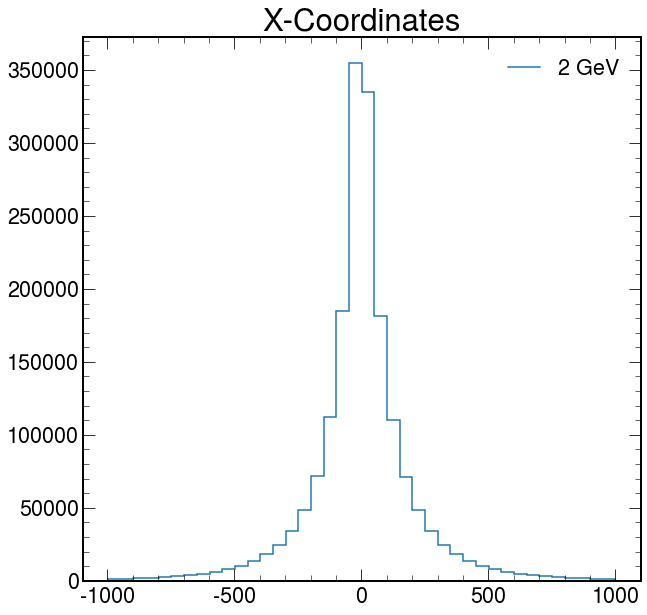

In [338]:
# np.histogram(xcoords, bins=200)
h, bins = np.histogram(xcoords1, bins=40)
fig, ax = plt.subplots()
hep.histplot(h, bins, label="2 GeV")
plt.title('X-Coordinates')
plt.legend()

haHA VICTORY!!!

Although I believe the hcal ends at 1m (maybe slightly less) from its center in both directions for the x-axis (based on the accumulation of data points near those values), there are 208 rechits that fall outside of the range [-1000, 1000], which account for $\approx 0.587%$ of all rechits.

However, note that when the bin number is set $\geq 200$, a peak-and-valley pattern appears. I investigate this below by determining how many elements of xcoords have an integer value in disguise (since they're all floats right now):

In [48]:
xint = np.empty_like(xcoords)

for i in range(xcoords.size):
    xint[i] = int(xcoords[i])
    
x = xcoords[xcoords==xint]

print("The number of x elements that are essentially integers is: {}".format(x.size))
print("The proportion of x elements that are essentially integers is: {:.3f}".format(x.size/xcoords.size))

The number of x elements that are essentially integers is: 1713216
The proportion of x elements that are essentially integers is: 0.511


Interestingly enough, half of the x-coordinates of the reconstructed hits are integers. Check if this trend holds for other coordinates:

In [49]:
yint = np.empty_like(ycoords)

for i in range(ycoords.size):
    yint[i] = int(ycoords[i])
    
y = ycoords[ycoords==yint]

print("The number of y elements that are essentially integers is: {}".format(y.size))
print("The proportion of y elements that are essentially integers is: {:.3f}".format(y.size/ycoords.size))
print()

zint = np.empty_like(zcoords)

for i in range(zcoords.size):
    zint[i] = int(zcoords[i])
    
z = zcoords[zcoords==zint]

print("The number of z elements that are essentially integers is: {}".format(z.size))
print("The proportion of z elements that are essentially integers is: {:.3f}".format(z.size/zcoords.size))

The number of y elements that are essentially integers is: 1662269
The proportion of y elements that are essentially integers is: 0.496

The number of z elements that are essentially integers is: 3350691
The proportion of z elements that are essentially integers is: 1.000


While this is probably not an issue and I likely just spent 20 minutes not moving toward graphing other information, I thought it was noteworthy and I would like to know why this is happening.

Now I'm going to produce a scatterplot of x-coordiates vs y-coordinates. I will possibly dive into a 3D scatterplot as well that includes z-coordinates too, but we shall see.

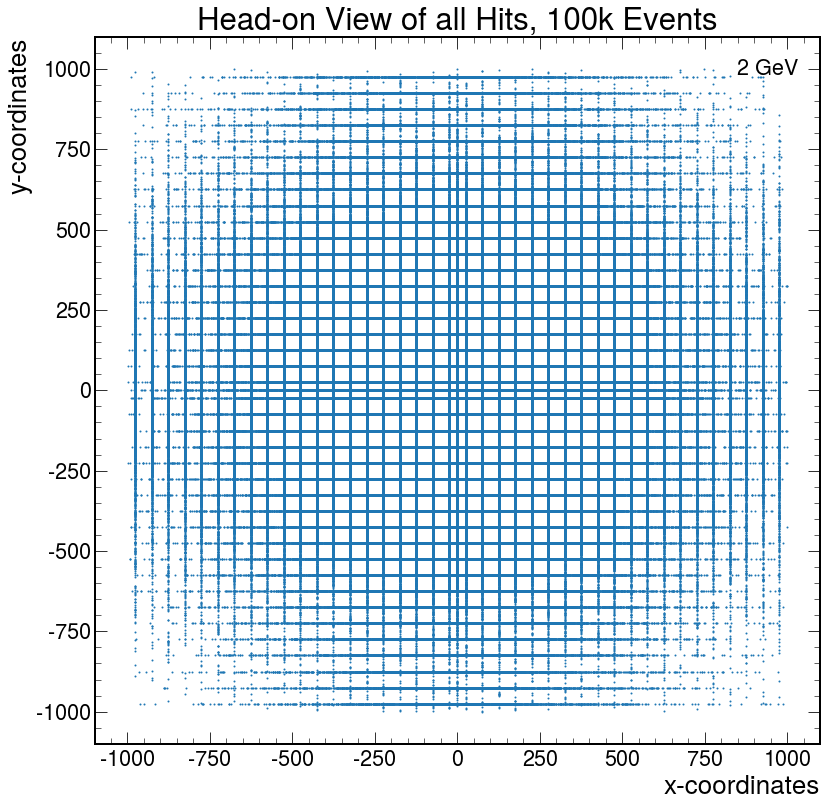

In [64]:
# 2D scatterplot of x and y
# %matplotlib inline
plt.figure(figsize=(13,13))
plt.title('Head-on View of all Hits, 100k Events')
plt.xlabel('x-coordinates')
plt.ylabel('y-coordinates')
# plt.xlim(-980, 990)
# plt.ylim(-930, 930)
plt.scatter(xcoords, ycoords, s=1, label='2 GeV')
plt.legend(loc=1)

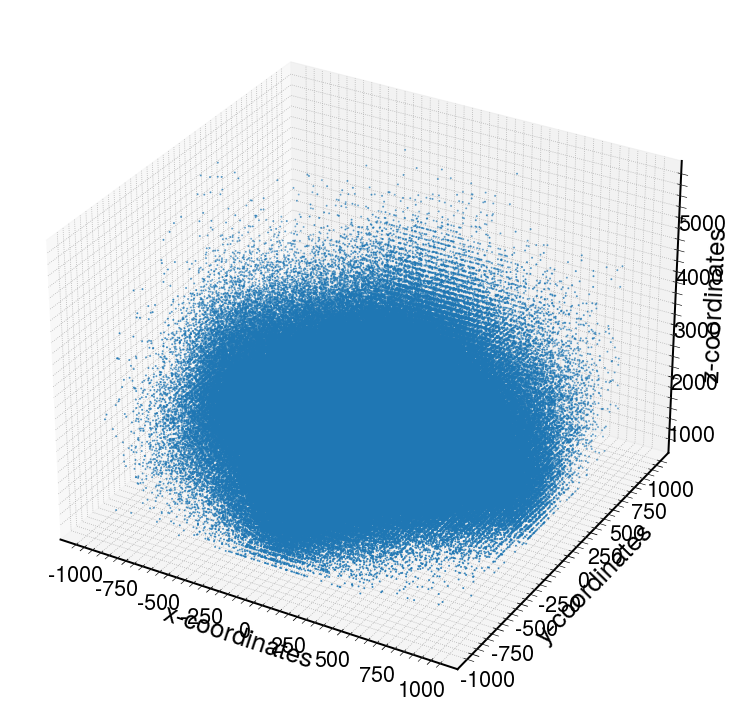

In [66]:
# 3d scatterplot
# %matplotlib notebook
fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(projection='3d')

ax.scatter(xcoords, ycoords, zcoords, s=1)

# plt.xlim(-1500, 1500)
# plt.ylim(-2000, 2000)

ax.set_xlabel('x-coordinates')
ax.set_ylabel('y-coordinates')
ax.set_zlabel('z-coordinates')

plt.show()

In [67]:
zcoords.max()

5681.0

All right so now I'm curious about the hits that seem to fall outside the Hcal. Let's make an array with (x, y, z), grab the triplets with $z>690.6$, and see where the x and y fall:

In [68]:
coords = np.zeros((xcoords.size, 3), dtype='float')
coords[:,0] = xcoords
coords[:,1] = ycoords
coords[:,2] = zcoords

In [69]:
backcoords = coords[coords[:,2]>=690.6]

count = 0
for i in backcoords:
    if i[0]<-980 or i[0]>980 or i[1]<-930 or i[1]>930:
        count +=1
    
print(count)

4396


Therefore, if the lines on the xy plot are indicative of the borders of the Hcal, it seems as though 479 hits are being detected outside of the Hcal. Which is quite clearly *weird*.

## minLayerWithHit Analysis

As per Christian's request on 6/17/22, I will now graph the minimum layer that has a hit for each event. First I will need to rerun the analysis file with the criteria to create an array with these values (I just edited Step 1). Now I can create a histogram and further numpy analyses:

First we have the **2GeV analysis**:

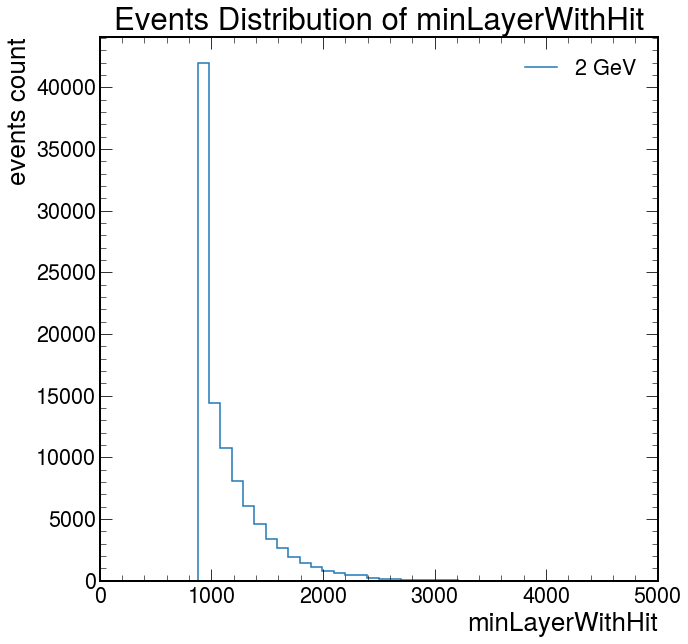

In [70]:
# minLayerWithHit histogram
# NOTE THAT THIS GRAPHS ZPOSITION, NOT ACTUAL LAYER NUMBER!!
nbins = 90

# 2Gev
h, bins = np.histogram(minLayerWithHit, bins=nbins)
# fig, ax = plt.subplots()
xxx = plt.axes(xlabel='minLayerWithHit', ylabel='events count', title='Events Distribution of minLayerWithHit')
plt.xlim(0, 5000)
hep.histplot(h, bins, label='2 GeV')

plt.legend()

In [77]:
print('2 GeV')
print("The number of events with no significant photoelectron production is: {}".format(minLayerWithHit[minLayerWithHit==9999].size))
print("The maximum depth for first appearance of >=100 photoelectrons is: {} mm".format(np.where(minLayerWithHit==minLayerWithHit.max(), 0, minLayerWithHit).max()))
print("The number of events that have this maximum depth is: {}".format(np.where(minLayerWithHit==minLayerWithHit.max(), 0, minLayerWithHit).max().size))

2 GeV
The number of events with no significant photoelectron production is: 163
The maximum depth for first appearance of >=100 photoelectrons is: 5436.0 mm
The number of events that have this maximum depth is: 1


In [78]:
maxinc = np.zeros((nbins, 2), dtype='float')
maxinc[:,0] = h
maxinc[:,1] = bins[bins<bins.max()]

In [79]:
# this calculates the 'highest positive derivative' for bin size
jumpindex = -1
# esum = 0

for i in range(1,maxinc.size):
#     esum = esum + maxinc[i,0]
    if maxinc[i,0] > 50:  # 10*maxinc[i-1,0] <-- this might be useful for much larger datasets
        jumpindex=i        # could also do something like '> esum*4'
        break
        
# print(esum)

# rebound = minLayerWithHit[minLayerWithHit<maxinc[jumpindex,1]].size
rebound = minLayerWithHit[minLayerWithHit<690.6].size
print('The number of neutrons that produced a significant number of photoelectrons from rebounding is: {}'.format(rebound))

The number of neutrons that produced a significant number of photoelectrons from rebounding is: 0


And now the analysis for **1GeV**:

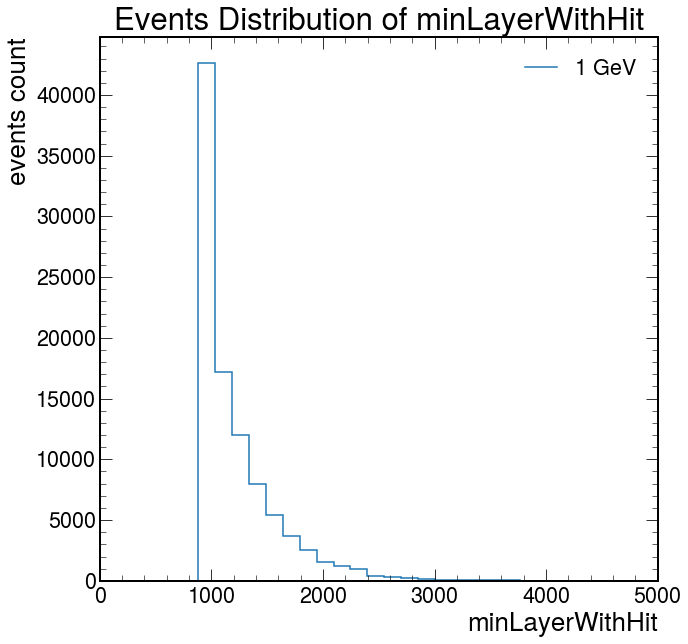

In [83]:
# minLayerWithHit histogram
# NOTE THAT THIS GRAPHS ZPOSITION, NOT ACTUAL LAYER NUMBER!!
nbins = 60

# 1Gev
h, bins = np.histogram(minLayerWithHit1, bins=nbins)
# fig, ax = plt.subplots()
xxx = plt.axes(xlabel='minLayerWithHit', ylabel='events count', title='Events Distribution of minLayerWithHit')
plt.xlim(0, 5000)
hep.histplot(h, bins, label='1 GeV')

plt.legend()

In [84]:
print('2 GeV')
print("The number of events with no significant photoelectron production is: {}".format(minLayerWithHit1[minLayerWithHit1==9999].size))
print("The maximum depth for first appearance of >=100 photoelectrons is: {} mm".format(np.where(minLayerWithHit1==minLayerWithHit1.max(), 0, minLayerWithHit1).max()))
print("The number of events that have this maximum depth is: {}".format(np.where(minLayerWithHit1==minLayerWithHit1.max(), 0, minLayerWithHit1).max().size))

2 GeV
The number of events with no significant photoelectron production is: 3446
The maximum depth for first appearance of >=100 photoelectrons is: 5093.0 mm
The number of events that have this maximum depth is: 1


In [85]:
# this calculates the 'highest positive derivative' for bin size
jumpindex = -1
# esum = 0

for i in range(1,maxinc.size):
#     esum = esum + maxinc[i,0]
    if maxinc[i,0] > 50:  # 10*maxinc[i-1,0] <-- this might be useful for much larger datasets
        jumpindex=i        # could also do something like '> esum*4'
        break
        
# print(esum)

# rebound = minLayerWithHit1[minLayerWithHit1<maxinc[jumpindex,1]].size
rebound = minLayerWithHit1[minLayerWithHit1<690.6].size
print('The number of neutrons that produced a significant number of photoelectrons from rebounding is: {}'.format(rebound))

The number of neutrons that produced a significant number of photoelectrons from rebounding is: 0


Let's plot these together using pyplot because I don't know how to use hep yet.

Text(0.5, 1.0, 'Events Distribution of minLayerWithHit')

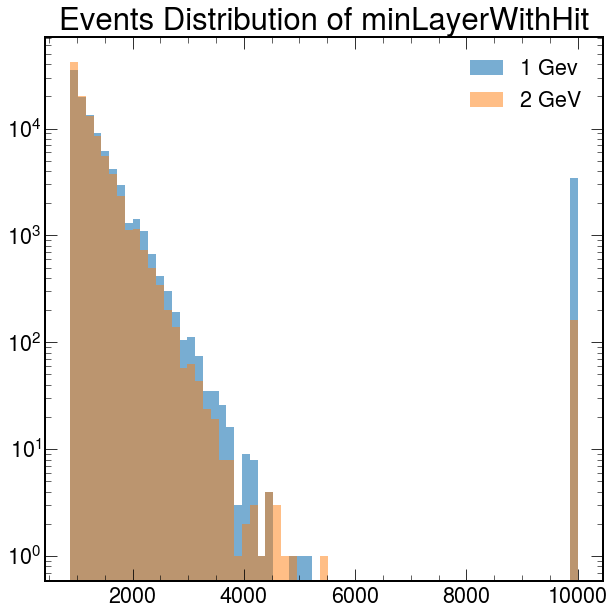

In [346]:
h1 = plt.hist(minLayerWithHit1, bins=65, label='1 Gev', alpha=0.6)
h = plt.hist(minLayerWithHit, bins=65, label='2 GeV', alpha=0.5)
# plt.xlim(0, 4000)
plt.legend()
plt.yscale('log')
plt.title('Events Distribution of minLayerWithHit')

Although the distributions are decently similar, it appears that the 2 GeV distribution drops off slightly quicker than the 1 GeV distribution.

## Analysis of Energy Scale Resolution of Hcal

To quantify the energy scale resolution of the hcal, we use the array sumenergy and find the mean and RMS of this distribution.

Create a function for the Root Means Square:

In [91]:
def rms(array):
    '''
    Calculates RMS of an array
    '''
    return np.sqrt((1/array.size) * np.sum(array**2))

In [92]:
def std(array):
    '''
    Calculates the standard deviation of an array
    '''
    return np.sqrt((1/array.size) * np.sum((array-np.mean(array))**2))

First look at this for **2 GeV**:

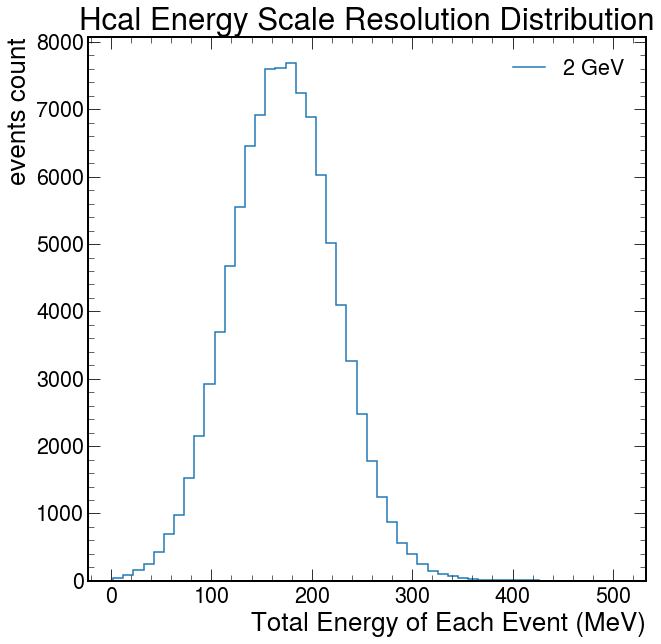

In [93]:
nbins = 50

# 2Gev
h, bins = np.histogram(sumenergy, bins=nbins)
xxx = plt.axes(xlabel='Total Energy of Each Event (MeV)', ylabel='events count', title='Hcal Energy Scale Resolution Distribution')
hep.histplot(h, bins, label='2 GeV')

plt.legend()

In [94]:
print('2 GeV')
print('The mean energy of the distribution is: {:.4f} MeV'.format(np.mean(sumenergy)))
# print('The RMS of the distribution is: {:.4f} MeV'.format(rms(sumenergy)))
print('The standard deviation of the distribution is: {:.4f} MeV'.format(std(sumenergy)))
print('The minimum energy in the distribution is: {:.4f} MeV'.format(sumenergy.min()))

2 GeV
The mean energy of the distribution is: 171.9360 MeV
The standard deviation of the distribution is: 52.2074 MeV
The minimum energy in the distribution is: 2.0027 MeV


Now look at **1 GeV**:

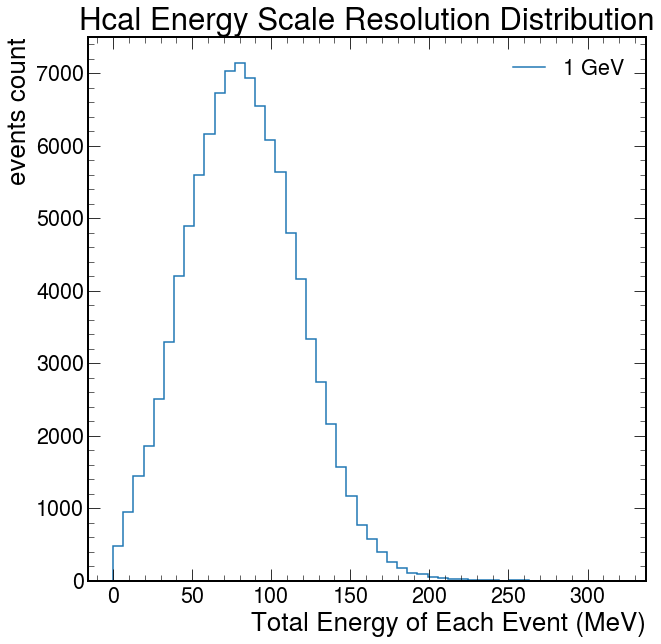

In [95]:
nbins = 50

# 1Gev
h, bins = np.histogram(sumenergy1, bins=nbins)
xxx = plt.axes(xlabel='Total Energy of Each Event (MeV)', ylabel='events count', title='Hcal Energy Scale Resolution Distribution')
hep.histplot(h, bins, label='1 GeV')

plt.legend()

In [147]:
print('1 GeV')
print('The mean energy of the distribution is: {:.4f} MeV'.format(np.mean(sumenergy1)))
# print('The RMS of the distribution is: {:.4f} MeV'.format(rms(sumenergy1)))
print('The standard deviation of the distribution is: {:.4f} MeV'.format(std(sumenergy1)))
print('The minimum energy in the distribution is: {:.4f} MeV'.format(sumenergy1.min()))
print('The number of elements that have this minimum energy is: {}'.format(sumenergy1[sumenergy1==sumenergy1.min()].size))

1 GeV
The mean energy of the distribution is: 82.6368 MeV
The standard deviation of the distribution is: 35.3964 MeV
The minimum energy in the distribution is: 0.0000 MeV
The number of elements that have this minimum energy is: 12


Plot both together. A 2-Sample T-Test with unequal variances shows that the 1 GeV distribution values are significantly smaller than the 2 GeV distribution values:

Text(0.5, 1.0, 'Hcal Energy Scale Resolution Distribution')

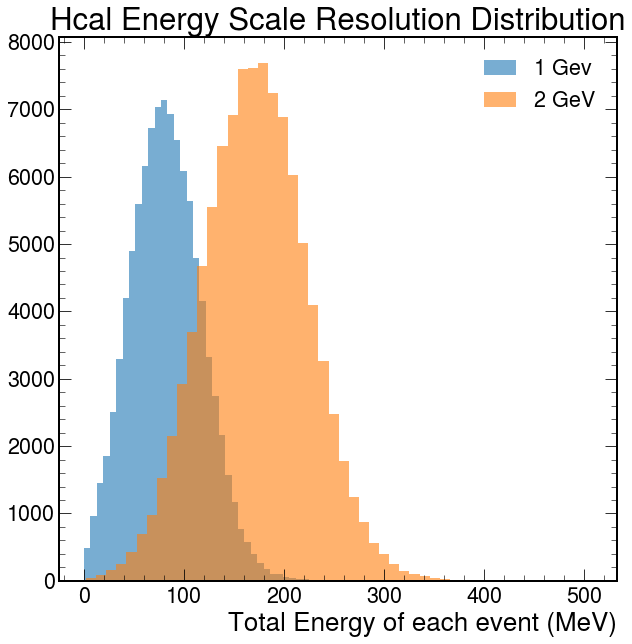

In [97]:
h1 = plt.hist(sumenergy1, bins=50, label='1 Gev', alpha=0.6)
h = plt.hist(sumenergy, bins=50, label='2 GeV', alpha=0.6)
plt.legend()
plt.xlabel('Total Energy of each event (MeV)')
plt.title('Hcal Energy Scale Resolution Distribution')

## Conclusions

From both sumenergy and minLayerWithHit analyses, I conclude that 2 GeV neutrons deposit enough energy to be easily tracked by the Hcal, whether they are measured based on if/when they produce a spray of $\geq 100$ photoelectrons or based on their total energy deposited. However, 22 out of 1000 1 GeV neutrons never produced a single hit with $\geq 100$ photoelectrons, and the minimum value is 11.3865 MeV (I'm not sure how sensitive our equipment is and if this would be a concern). This means that it is more likely for the Hcal to miss the detection of a 1 GeV neutron and incorrectly tag this event as an instance of dark matter production.

# Tuesday, June 21 and Wednesday, June 22

**About the detector:** Recall the plots that Christian showed us that demonstrate the QM peaks for the photoelectrons that are produced as noise. We can plan to veto an event when only one photoelectron is produced, but because of the randomness we'd be throwing out half our data. When we increase the threshold to 5 photoelectrons we're only throwing out 5% of our data. Therefore we ideally want a high enough threshold that we don't throw out too much data, but a low enough threshold that we catch all the neutrons.

To-do list:
- for each event, find the hit that produced the most photoelectrons and graph that max number.
- look at rms
- $ \bar{x} = \frac{\sum x_{hit} \cdot E_{hit}}{\sum E_{hit}}$ (do for y and z as well)

## Hit with most photoelectrons per event

2 GeV:

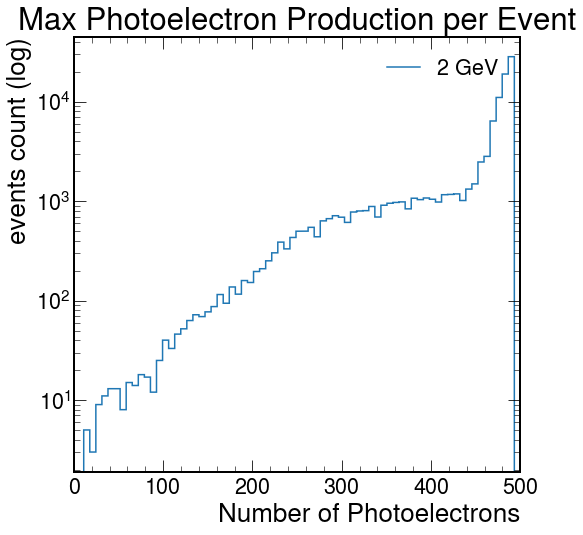

In [164]:
nbins = 600

# 2Gev
plt.figure(figsize=(8,8))
h, bins = np.histogram(maxPEhit, bins=nbins)
xxx = plt.axes(xlabel='Number of Photoelectrons', ylabel='events count (log)', title='Max Photoelectron Production per Event')
hep.histplot(h, bins, label='2 GeV')
plt.xlim(0,500)
plt.yscale('log')
plt.legend()

In [160]:
# Some distribution statistics
print("2 GeV:")
print()
print("Maximum photoelectrons produced under 200: {}".format(maxPEhit[maxPEhit<200]))
print("Maximum photoelectrons produced under 50 size: {}".format(maxPEhit[maxPEhit<50].size))
print("Minimum of distribution: {}".format(maxPEhit.min()))
print()
print("Maximum of distribution: {}".format(maxPEhit.max()))
print("Number of elements with the distribution max: {}".format((maxPEhit[maxPEhit == maxPEhit.max()]).size))
print("PE numbers over 1000: {}".format(maxPEhit[maxPEhit > 1000]))
# print("20th percentile is at about {} photoelectrons.".format(400))
# maxPEhit[maxPEhit<400].size / maxPEhit.size

2 GeV:

Maximum photoelectrons produced under 200: [184. 197. 159. ... 135. 123.  11.]
Maximum photoelectrons produced under 50 size: 50
Minimum of distribution: 11.0

Maximum of distribution: 4087.0
Number of elements with the distribution max: 6
PE numbers over 1000: [2042. 4087. 4087. 4087. 4087. 2042. 4087. 2042. 2042. 4087. 2042.]


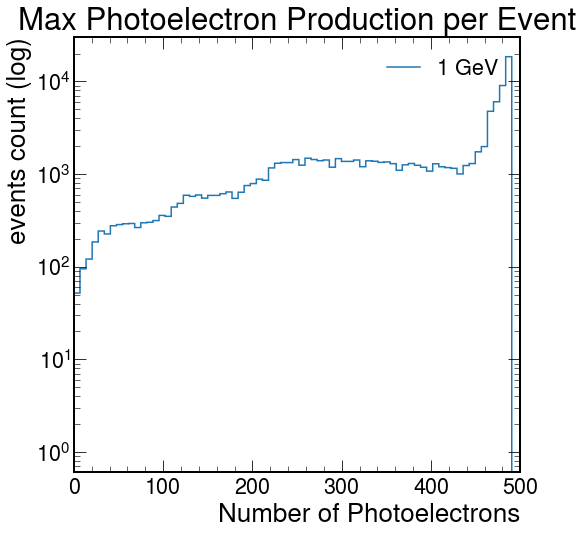

In [166]:
nbins = 600

# 1 Gev
plt.figure(figsize=(8,8))
h, bins = np.histogram(maxPEhit1, bins=nbins)
xxx = plt.axes(xlabel='Number of Photoelectrons', ylabel='events count (log)', title='Max Photoelectron Production per Event')
hep.histplot(h, bins, label='1 GeV')
plt.xlim(0,500)
plt.yscale('log')
plt.legend()

In [167]:
# Some distribution statistics
print("1 GeV:")
print()
print("Maximum photoelectrons produced under 200: {}".format(maxPEhit1[maxPEhit1<200]))
print("Maximum photoelectrons produced under 50 size and proportion: {}, {}".format(maxPEhit1[maxPEhit1<50].size, maxPEhit1[maxPEhit1<50].size/maxPEhit1.size))
print("Minimum of distribution: {}".format(maxPEhit1.min()))
print("Number of elements with this minimum: {}".format(maxPEhit1[maxPEhit1==maxPEhit1.min()].size))
print()
print("Maximum of distribution: {}".format(maxPEhit1.max()))
print("Number of elements with the distribution max: {}".format((maxPEhit1[maxPEhit1 == maxPEhit1.max()]).size))
print("PE numbers over 1000: {}".format(maxPEhit1[maxPEhit1 > 1000]))
# print("20th percentile is at about {} photoelectrons.".format(400))
# maxPEhit[maxPEhit<400].size / maxPEhit.size

1 GeV:

Maximum photoelectrons produced under 200: [144.  94. 118. ... 105. 115. 122.]
Maximum photoelectrons produced under 50 size and proportion: 1277, 0.01277
Minimum of distribution: 0.0
Number of elements with this minimum: 12

Maximum of distribution: 4087.0
Number of elements with the distribution max: 1
PE numbers over 1000: [4087. 2042.]


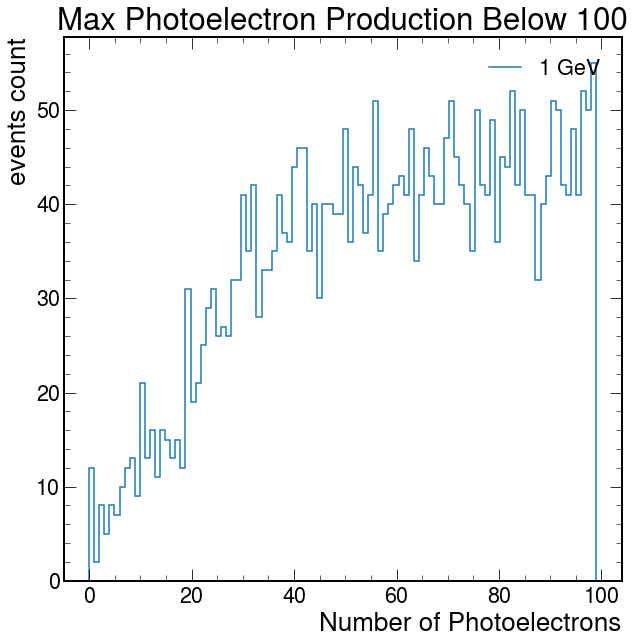

In [138]:
nbins = 100

# 1 Gev below 100 photoelectrons
h, bins = np.histogram(maxPEhit1[maxPEhit1<100], bins=nbins)
xxx = plt.axes(xlabel='Number of Photoelectrons', ylabel='events count', title='Max Photoelectron Production Below 100')
hep.histplot(h, bins, label='1 GeV')

plt.legend()

In [139]:
print("Min value: {}".format(maxPEhit1[maxPEhit1<100].min()))

Min value: 0.0


Text(0.5, 1.0, 'Max Photoelectron Production per Event')

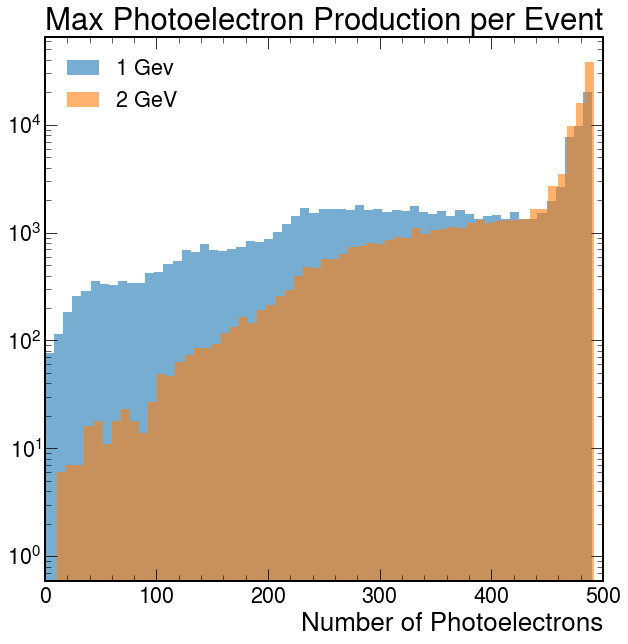

In [168]:
h1 = plt.hist(maxPEhit1, bins=500, label='1 Gev', alpha=0.6)
h = plt.hist(maxPEhit, bins=500, label='2 GeV', alpha=0.6)
plt.xlim(0,500)
plt.yscale('log')
plt.legend()
plt.xlabel('Number of Photoelectrons')
plt.title('Max Photoelectron Production per Event')

### Analysis

The 2 GeV distribution is extremely skewed to the left, with 20% of max hits below 400, less than 1% below 200, and none below 120. 108 max hits ($\approx$10% of the distribution) achieve the max value of 490 photoelectrons. *Is this number of photoelectrons the 'overload' limit for the Hcal?*

The 1 GeV distribution is still skewed to the left, but it has a much fatter tail than 2 GeV, with 22 max hits below 100 photoelectrons. These lowest max hits seem to be more or less randomly distributed throughout their range. The minimum max hit produced 44 photoelectrons, but in terms of the <100 distribution, it is clearly not an outlier. More simulations are needed to better solidify the value of this minimum so that useful data collection can be maximized.

## Eliminating Rebound Hits

There are three ways in which this can be done. If we have the following situation: a neutron hits (1) the main part of the hcal, then (2) the donut part, then (3) the main part of the hcal again, we can eliminate using one of the following schemes:

1) Eliminate just 2 (can be done easily on Jupyter notebook)

2) Eliminate 2 and 3 (can be done easily in plain text)

3) Eliminate all three (can be done with some work in plain text)

We are now waiting on Christian so see which one we should do... He told us we should just eliminate using the criteria from (1) since the hit sequence is happening at essentially light speed. I edited the plain text pickle creation files to account for this and reran everything. There are no significant differences in the above distributions.

## Energy-Weighted Position Distributions

Text(0.5, 1.0, 'Reconstructed Hit Energy Distribution')

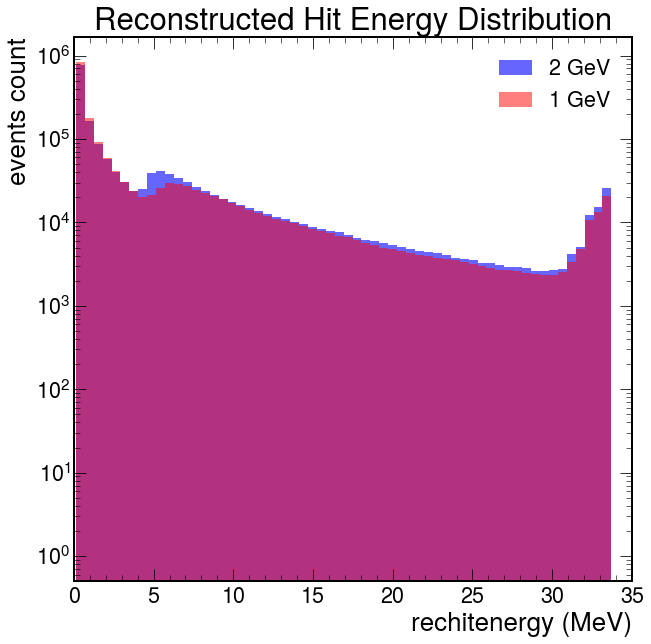

In [212]:
h = plt.hist(rechitenergy[0:rechitenergy1.size], bins=500, label='2 GeV', alpha=0.6, color='b')
# h = plt.hist(rechitenergy, bins=500, label='2 GeV', alpha=0.6, color='b')
h1 = plt.hist(rechitenergy1, bins=500, label='1 GeV', alpha=0.5, color='r')
plt.legend(loc=1)
plt.xlabel('rechitenergy (MeV)')
plt.ylabel('events count')
plt.xlim(0,35)
plt.yscale('log')
plt.title('Reconstructed Hit Energy Distribution')

(The 2 GeV is in blue and the 1 GeV is in red.) 

As expected, the x-coordinate and y-coordinate graphs are practically identical. The 2 GeV distributions have a very slightly larger spread in terms of the hit positions. While very low-energy hits (<5 MeV) occur over the entire coordinate range, higher-energy hits are focused around 0 mm, the middle of the Hcal. 

The z-coordinate graph shows a similar trend in terms of spread. In this graph, the high energy hits occur at smaller z-coordinates while the low energy hits occur throughout the Hcal, which produces the roughly triangular shape above (with the hypotenuse being more like an exponential decay curve).

If hits are thought of as sequential, it makes sense that these trends would appear. First, the neutrons are not fired at an angle; second, a head-on collision would produce a higher-energy hit (I think); and third, head-on collisions cause more drastic deflections than glancing collisions. Combining these three facts shows that even with low-energy collisions along the way, the neutron's path stays close to (0, 0, z) unless a higher-energy collision knocks it off-course and allows it to have lower-energy collisions farther away from this initial path.

In all three graphs, the reconstructed hit energy seems to be limited to a maximum of about 33.617 MeV, which causes clumping of the simulated data as this maximum is approached. I hypothesize that if the energy range and sensitivity of the Hcal were adjusted, there would be reconstructed hit energies with values higher than this maximum. There is also an interesting increase in the amount of hits going from an energy of 4 MeV to 5 MeV. I don't know what is causing this but I would be very interested to find out.

# Wednesday, June 22

I am now going to make a plot that graphs coordinate bins of energy with each bin having its mean and standard deviation displayed.

I'm going to work with x-coordinates first (as always). Here's the plan of attack:

1) Form a 2D array. Each row will have the ordered pair (coordinate, energy).

2) We then do binning with the coordinates.

3) Then we use numpy operations to find mean and standard deviation of each bin in terms of position.

4) Find mean and standard deviation of energy within each bin too.

5) Graphing:

    - graph points that are (coordinate mean, energy mean) for each bin
    - do some really fun research on how to graph error bars and graph those
    
Ok let's do it:

In [253]:
def calc_bins(a1, a2, nbins=15):
    '''
    Gives bins to be used in histogram
    
    Inputs:
        - a1 (numpy array): coordinate array for first neutron energy (e.g. 1 GeV)
        - a2 (numpy array): coordinate array for second neutron energy (e.g. 2 GeV)
        - nbins (int): starting number of desired bins
        
    Outputs:
        - (bins) (numpy array): array of bins to be used in histogram
    '''
    
    h1, bins1 = np.histogram(a1, bins=nbins)
    h2, bins2 = np.histogram(a2, bins=nbins)
    
    
    if bins1[0]<=bins2[0] and bins1[-1]>=bins2[-1]:
        return bins1
    
    
    elif bins2[0]<=bins1[0] and bins2[-1]>=bins1[-1]:
        return bins2
    
    
    elif bins1[0]<=bins2[0]:
        bins1_list = list(bins1)
        
        while bins1_list[-1]<bins2[-1]:
            diff = bins1_list[-1] + (bins1[1]-bins1[0])
            bins1_list.append(diff)
            
        bins1_array = np.array(bins1_list)
        return bins1_array
    
    
    elif bins2[0]<=bins1[0]:
        bins2_list = list(bins2)
        
        while bins2_list[-1]<bins1[-1]:
            diff = bins2_list[-1] + (bins2[1]-bins1[0])
            bins2_list.append(diff)
            
        bins2_array = np.array(bins2_list)
        return bins2_array

In [257]:
def ms_and_qs(xy, bins, low=0.16, high=0.84):
    '''
    Calculates median and middle "68% quantile" for each bin of the 2D 
    array containing (coordinates, hit energies)
    
    Inputs:
        - xy (numpy array): aformentioned 2D array
        - bins (numpy array): output from calc_bins function, the binning
                              to be used in the future histogram
        - low (float on [0,1]): lower percentile for quantile range
        - high (float on [0,1]): higher percentile for quantile range
                              
    Outputs:
        - medians (numpy array): 2D array containing bin medians of
                                 coordinates and energies
        - q_low (numpy array): 2D array containing 16th quartile value of
                               coordinates and energies
        - q_high (numpy array): 2D array containing 84th quartile value of
                                coordinates and energies
    '''
    
    nb = bins.size
    
    medians = np.zeros((nb-1, 2), dtype='float')
    q_low   = np.zeros((nb-1, 2), dtype='float')
    q_high  = np.zeros((nb-1, 2), dtype='float')
    
    
    for i in range(nb-1):
    
        xx = xy[:,0][xy[:,0]>=bins[i]]
        xxx = xx[xx<bins[i+1]]
    
        if xxx.size==0:
            medians[i,0] = bins[i]
            q_low[i,0] = 0
            q_high[i,0] = 0
        else:
            medians[i,0] = np.median(xxx)
            q_low[i,0] = medians[i,0] - np.quantile(xxx, low)
            q_high[i,0] = np.quantile(xxx, high) - medians[i,0]
    
            if i==(nb-1):
                xx = xy[:,0][xy[:,0]>=bins[i]]
                xxx = xx[xx<=bins[i+1]]
                medians[i,0] = np.median(xxx)
                q_low[i,0] = medians[i,0] - np.quantile(xxx, low)
                q_high[i,0] = np.quantile(xxx, high) - medians[i,0]
                
                
    for i in range(nb-1):
    
        z1 = xy[:,0][xy[:,0]>=bins[i]]
        ez1 = xy[:,1][xy[:,0]>=bins[i]]

        zez1 = np.zeros((ez1.size, 2), dtype='float')
        zez1[:,0] = z1
        zez1[:,1] = ez1

        zz1 = zez1[:,1][zez1[:,0]<bins[i+1]]

        if zz1.size==0:
            medians[i,1] = 0
            q_low[i,1] = 0
            q_high[i,1] = 0
        else:
            medians[i,1] = np.median(zz1)
            q_low[i,1] = medians[i,1] - np.quantile(zz1, low)
            q_high[i,1] = np.quantile(zz1, high) - medians[i,1]

            if i==(nbins-1):
                z1 = xy[:,0][xy[:,0]>=bins[i]]
                ez1 = xy[:,1][xy[:,0]>=bins[i]]

                zez1 = np.zeros((ez1.size, 2), dtype='float')
                zez1[:,0] = z1
                zez1[:,1] = ez1

                zz1 = zez1[:,1][zez1[:,0]<=bins[i+1]]

                medians[i,1] = np.median(zz1)
                q_low[i,1] = medians[i,1] - np.quantile(zz1, low)
                q_high[i,1] = np.quantile(zz1, high) - medians[i,1]
                
                
    return medians, q_low, q_high

In [306]:
def ms_qs_graph(medians, q_lows, q_highs, coord, energies, fs=12, ms=8, loc='best'):
    '''
    Graphs the medians and quantiles as returned from the function 
    ms_and_qs
    
    Inputs:
        - medians (numpy array): 3D array where each 2D slice
                                 is the first output from ms_and_qs
        - q_lows (numpy array): 3D array where each 2D slice
                                is the second output from ms_and_qs
        - q_highs (numpy array): 3D array where each 2D slice
                                 is the third output from ms_and_qs
        - coord (str): name of the coordinate under analysis; takes
                       values of 'x', 'y', 'z'
        - energies (list): contains energies of the fired neutrons
                           for each 2D array slice
                       
    Outputs:
        - matplotlib scatterplot of median positions and energies,
          along with their respective quantiles, for each position 
          bin
    '''
    
    colors = plt.cm.Set1(np.linspace(0, 1, medians.shape[0]))  # change the color scheme here if you like
    
    plt.figure(figsize=(fs,fs))
    plt.title('Median Hit Energy vs Median {}-Coordinates'.format(coord.upper()))
    plt.xlabel('median {}-coordinates of hit (mm)'.format(coord.lower()))
    plt.ylabel('median energy of hit (MeV)')
    
    for i in range(medians.shape[0]):
        plt.errorbar(medians[i,:,0], medians[i,:,1], xerr=q_lows[i,:,0], yerr=q_lows[i,:,1], uplims=True, xuplims=True, 
                     marker='o', ms=ms, label='{} GeV'.format(energies[i]), lw=0, elinewidth=2, color=colors[i])
        plt.errorbar(medians[i,:,0], medians[i,:,1], xerr=q_highs[i,:,0], yerr=q_highs[i,:,1], lolims=True, xlolims=True, 
                     marker='o', ms=ms, lw=0, elinewidth=2, color=colors[i])
        
    plt.legend(loc=loc)

## X-Coordinates

In [307]:
# form 2D arrays

xenergy1 = np.zeros((xcoords1.size, 2), dtype='float')
xenergy1[:,0] = xcoords1
xenergy1[:,1] = rechitenergy1

xenergy = np.zeros((xcoords.size, 2), dtype='float')
xenergy[:,0] = xcoords
xenergy[:,1] = rechitenergy

In [347]:
# find appropriate bins, then medians and quantiles of bin distributions
bins = calc_bins(xenergy1[:,0], xenergy[:,0])

m1, ql1, qh1 = ms_and_qs(xenergy1, bins)
m2, ql2, qh2 = ms_and_qs(xenergy, bins)

In [350]:
# set up for graphing

meds = np.zeros((2, m1.shape[0], 2), dtype='float')
meds[0] = m1
meds[1] = m2

ql = np.zeros((2, m1.shape[0], 2), dtype='float')
ql[0] = ql1
ql[1] = ql2

qh = np.zeros((2, m1.shape[0], 2), dtype='float')
qh[0] = qh1
qh[1] = qh2

energies = [1, 2]

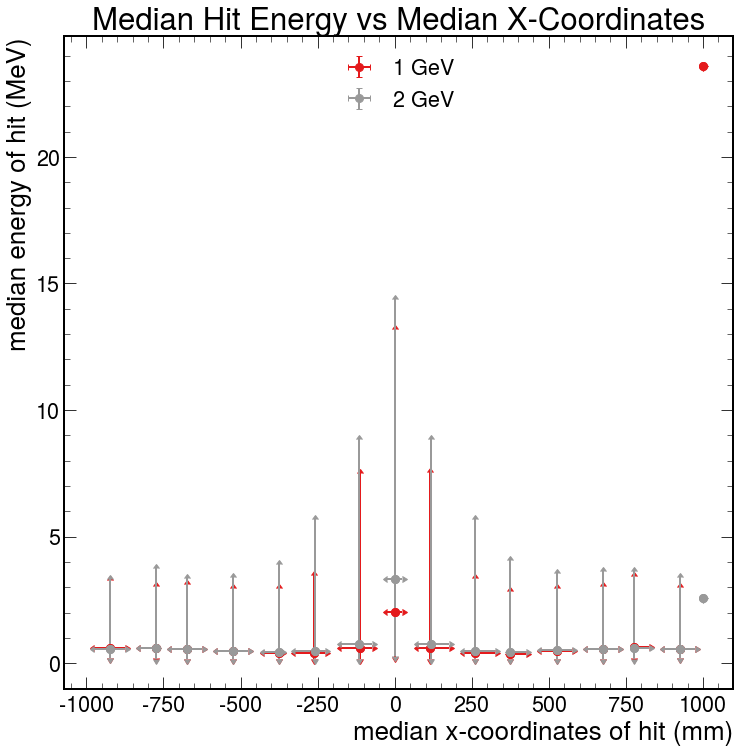

In [349]:
ms_qs_graph(meds, ql, qh, 'x', energies, loc=9)

## Y-Coordinates

In [314]:
# form 2D arrays

yenergy1 = np.zeros((ycoords1.size, 2), dtype='float')
yenergy1[:,0] = ycoords1
yenergy1[:,1] = rechitenergy1

yenergy = np.zeros((ycoords.size, 2), dtype='float')
yenergy[:,0] = ycoords
yenergy[:,1] = rechitenergy

In [315]:
# find appropriate bins, then medians and quantiles of bin distributions
bins = calc_bins(yenergy1[:,0], yenergy[:,0])

m1, ql1, qh1 = ms_and_qs(yenergy1, bins)
m2, ql2, qh2 = ms_and_qs(yenergy, bins)

In [313]:
# set up for graphing

meds = np.zeros((2, m1.shape[0], 2), dtype='float')
meds[0] = m1
meds[1] = m2

ql = np.zeros((2, m1.shape[0], 2), dtype='float')
ql[0] = ql1
ql[1] = ql2

qh = np.zeros((2, m1.shape[0], 2), dtype='float')
qh[0] = qh1
qh[1] = qh2

energies = [1, 2]

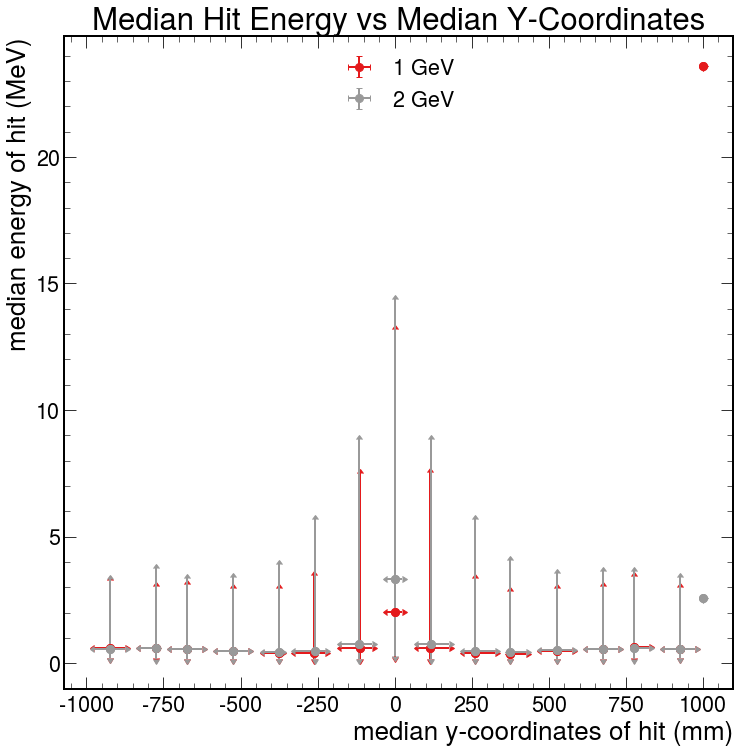

In [318]:
ms_qs_graph(meds, ql, qh, 'y', energies, loc=9)

# Z-Coordinates

In [319]:
# step 1 - form array

zenergy = np.zeros((zcoords.size, 2), dtype='float')
zenergy[:,0] = zcoords
zenergy[:,1] = rechitenergy

zenergy1 = np.zeros((zcoords1.size, 2), dtype='float')
zenergy1[:,0] = zcoords1
zenergy1[:,1] = rechitenergy1

In [320]:
bins = calc_bins(zenergy1[:,0], zenergy[:,0])

m1, ql1, qh1 = ms_and_qs(zenergy1, bins)
m2, ql2, qh2 = ms_and_qs(zenergy, bins)

In [321]:
meds = np.zeros((2, m1.shape[0], 2), dtype='float')
meds[0] = m1
meds[1] = m2

ql = np.zeros((2, m1.shape[0], 2), dtype='float')
ql[0] = ql1
ql[1] = ql2

qh = np.zeros((2, m1.shape[0], 2), dtype='float')
qh[0] = qh1
qh[1] = qh2

energies = [1, 2]

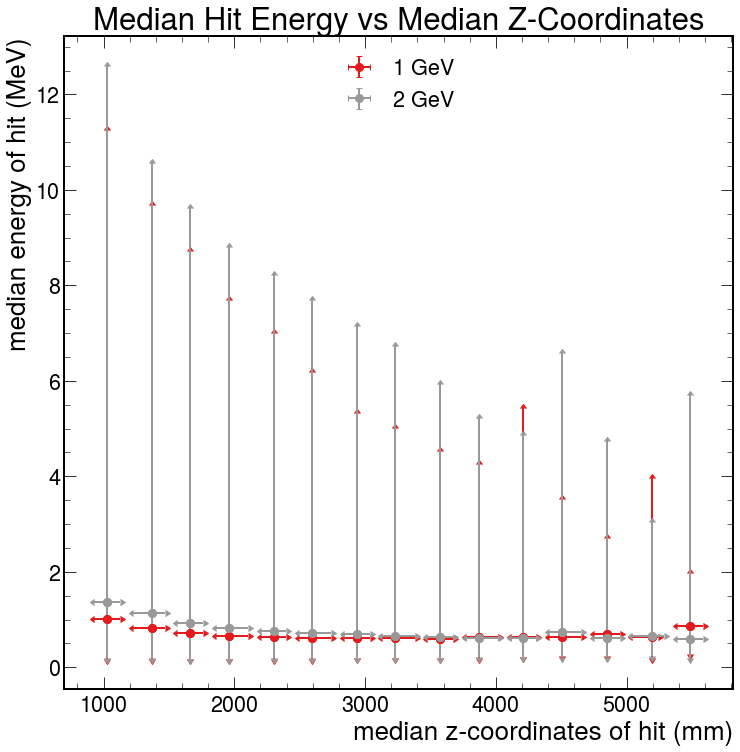

In [324]:
ms_qs_graph(meds, ql, qh, 'z', energies, loc=9)